# **UNIT TEST CASE ANALYSIS**

 Please use en_wiki_10k.txt file to perform layer wise intra sentence_similarity 

In [ ]:
#install the "datasets" and "transformers" libraries
! pip install datasets transformers

In [6]:
# required libraries 
import torch
import json
import progressbar
import argparse
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import numpy as np

In [7]:
#function loads a pre-trained language model and tokenize
def load_model_tokenizer(model_name):
    return AutoModel.from_pretrained(model_name), AutoTokenizer.from_pretrained(model_name)


In [8]:
#generates a diagonal mask matrix
def get_diag_mask_matrix(seqlen):
    m= np.zeros((seqlen, seqlen), float)
    np.fill_diagonal(m, 1.0)
    return 1.0 - m

In [9]:
#tokenizes a sentence using a given tokenizer object
def text_to_id(sentence, tokenizer, is_cuda, device):
    sentence = '[CLS] ' + sentence + ' [SEP]'
    token_id = torch.LongTensor(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence) )).view(1,-1)
    if is_cuda:
        token_id = token_id.cuda(device)
    return token_id


In [10]:
def compute_cosine_correlation_matrix(hidden_tensor):
    # retrieve the second dimension of hidden tensor to get the sequence length
    _, seq_leng, _ = hidden_tensor.size()
    # normalize hidden tensor along last dimension using PyTorch's norm method, divide each vector by its norm
    norm_hidden = hidden_tensor / hidden_tensor.norm(dim=2, keepdim=True) 
    # take transpose of normalized hidden tensor
    norm_hidden_transpose = norm_hidden.transpose(1, 2)
    # compute cosine similarity between each pair of vectors in the original tensor using dot product of normalized tensor and its transpose
    correlation_matrix = torch.matmul(norm_hidden, norm_hidden_transpose).view(seq_leng, seq_leng)
    # convert correlation matrix to NumPy array, detach from computation graph, and return
    return correlation_matrix.detach().cpu().numpy()


In [11]:

#function calculates the sum of cosine similarities

def compute_stat(hidden):
    # Compute the cosine similarity matrix for the input tensor
    cosine_correlation_matrix = compute_cosine_correlation_matrix(hidden)
    
    # Create a diagonal mask matrix to exclude diagonal elements from the sum of cosine similarities,Get the length of the sequence from the cosine similarity matrix
    mask_matrix = get_diag_mask_matrix(cosine_correlation_matrix.shape[0])
    
    # Check that the mask matrix has the same shape as the cosine similarity matrix
    assert mask_matrix.shape == cosine_correlation_matrix.shape
    
    # Apply the mask matrix to the cosine similarity matrix to exclude diagonal elements
    cosine_masked_matrix = cosine_correlation_matrix * mask_matrix

    #length of the sequence from the cosine similarity matrix
    seq_len  = cosine_correlation_matrix.shape[0]

    # Calculate the sum of cosine similarities between pairs of vectors, excluding diagonal elementstotal number of pairs of vectors in the sequence and return.
    return np.sum(cosine_masked_matrix) / 2, seq_len * (seq_len - 1) / 2


In [12]:
#function processes a single text instance using a language model and computes the cosine similarity sum and the total number of token pairs for each attention layer of the model
def process_one_instance(model, tokenizer, text, is_cuda, device):
    # initialize an empty dictionary to store the cosine similarity sum and the total number of token pairs for each attention layer
    res_dic = {}
    for id in range(1,13):
        # add an empty dictionary for each attention layer to the result dictionary
        res_dic[id] = {}
    # tokenize the input text and convert it to a tensor of token IDs
    input_id = text_to_id(text, tokenizer, is_cuda, device)
    # run the input through the language model and retrieve the hidden states for each attention layer
    outputs = model(input_id, output_hidden_states=True)
    attention_hidden_states = outputs[-1]
    for id in range(1,13):
        # compute the cosine similarity sum and the total number of token pairs for the current attention layer
        one_cosine_sum, one_token_num = compute_stat(attention_hidden_states[id])
        # add the cosine similarity sum and the total number of token pairs to the result dictionary for the current attention layer
        res_dic[id]['cosine_sum'] = one_cosine_sum
        res_dic[id]['token_sum'] = one_token_num
    # return the result dictionary
    return res_dic


In [13]:
# Function to parse command line arguments
def parse_config():
    # Create an argument parser
    parser = argparse.ArgumentParser()
    # Add three arguments to the parser: model_name, file_path, and output_path, all of type string
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--file_path", type=str)
    parser.add_argument("--output_path", type=str)
    # Parse the arguments from the command line and return them as a Namespace object
    return parser.parse_args()


In [14]:
#function is a wrapper function that performs layer-wise intra-sentence similarity analysis on a text file containing sentence

all_res_dict = {} # create an empty dictionary to store the output for each input text

def startAnalysis(model_name, file_path, output_path):
    # create an argument parser to take command-line arguments for model name, input file path, and output file path
    import argparse
    parser = argparse.ArgumentParser(description='Calculate layer-wise intra-sentence similarity using a BERT model.')
    parser.add_argument('--model_name', type=str, required=True, help='Name or path of the pre-trained BERT model')
    parser.add_argument('--file_path', type=str, required=True, help='Path to the text file containing sentences for similarity calculation')
    parser.add_argument('--output_path', type=str, required=True, help='Path to save the output JSON file')
    args = parser.parse_args([f"--model_name={model_name}", f"--file_path={file_path}", f"--output_path={output_path}"])

    # check if GPU is available
    if torch.cuda.is_available():
        print ('Cuda is available.')
    is_cuda = torch.cuda.is_available()

    # set the device to CUDA if available, otherwise use CPU
    device = torch.device('cuda') if is_cuda else torch.device('cpu')

    # load the specified pre-trained BERT model and tokenizer
    model, tokenizer = load_model_tokenizer(args.model_name)

    # move the model to CUDA if available
    if is_cuda:
        model = model.cuda(device)

    # set the model to evaluation mode
    model.eval()

    # read input text from the file and store in a list
    text_list = []
    with open(args.file_path, 'r', encoding='utf8') as i:
        lines = i.readlines()
        for l in lines:
            text_list.append(l.strip('\n'))

    # use progressbar to track progress while processing input texts
    import progressbar
    print('Start measuring intra-sentence similarity...')
    print('Number of text is {}'.format(len(text_list)))
    p = progressbar.ProgressBar(len(text_list))
    p.start()

    # loop over all input texts
    for idx in range(len(text_list)):
        p.update(idx)
        one_text = text_list[idx]
        one_res_dict = process_one_instance(model, tokenizer, one_text, is_cuda, device) # get the output for one input text
        all_res_dict[idx] = one_res_dict # store the output in the all_res_dict dictionary

    p.finish()
    print('Completed !')


In [ ]:
#The startAnalysis function will load the specified TACL BERT model and tokenizer, 
#read in the text file, and then process each sentence in the file using the process_one_instance function. 
#The results of the analysis will be saved to the specified output file in JSON form
startAnalysis(
    model_name='cambridgeltl/tacl-bert-base-uncased',
    file_path='./en_wiki_randomly_select_50k.txt',
    output_path='./tacl_result-2.json'
)

In [ ]:
#dictionary into a JSON file
with open('./tacl_resul.json', 'w') as outfile:
      json.dump(all_res_dict, outfile, indent=4)


In [ ]:
#The startAnalysis function will load the specified Bert model and tokenizer, 
#read in the text file, and then process each sentence in the file using the process_one_instance function. 
#The results of the analysis will be saved to the specified output file in JSON form
startAnalysis(
    model_name='bert-base-uncased',
    file_path='./en_wiki_randomly_select_50k.txt',
    output_path='./bert_resul.json'
)
#dictionary into a JSON file
with open('./bert_resul.json', 'w') as outfile:
      json.dump(all_res_dict, outfile, indent=4)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-f2c1a743b26b>", line 4, in <cell line: 4>
    startAnalysis(
  File "<ipython-input-29-45567aa91255>", line 23, in startAnalysis
    model, tokenizer = load_model_tokenizer(args.model_name)
  File "<ipython-input-22-8e4ab26a6363>", line 3, in load_model_tokenizer
    return AutoModel.from_pretrained(model_name), AutoTokenizer.from_pretrained(model_name)
  File "/usr/local/lib/python3.9/dist-packages/transformers/models/auto/auto_factory.py", line 471, in from_pretrained
    return model_class.from_pretrained(
  File "/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py", line 2089, in from_pretrained
    use_safetensors = kwargs.pop("use_safetensors", None if is_safetensors_available() else False)
  File "/usr/local/lib/python3.9/dist-packages/transform

In [16]:
#installs the latex Python package
!pip install latex
#Installs some required LATEX fonts and tools for creating PDFs from LATEX documents
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7603 sha256=d73eb4f6b5fd2aee744415879283c2a89a75d8bd554deb8161a8304f6f617407
  Stored in directory: /root/.cache/pip/wheels/94/84/e5/5ce582523fd479d00356867953085a67c47fbbc86506aa92f8
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7244 sha256=b79dea50516e05011431289efa01a817123ed78076363f0f136f4e3bc5cf840d
  Stored in directory: /root/.cache/pip/wheels/8a/0b/a3/37ca07d5a2838bba2e475e8090455e40b94631bd57a99a35f4
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2782 sha256=ec652b5cbd1870003a5348dee557845011a5dbca0e1406987f700b19db587827
  Stored in directory: /root/.cache/pip/wheels/84/c7/f5/fed66dce1ed897b44e

In [17]:
#Function calculates average similarity score for each layer.
def process_result(in_f):
    # Load the result JSON file
    with open(in_f) as f:
        res_dict = json.load(f)
    # Print the number of instances
    print (len(res_dict))
    
    # Create a dictionary to store the cross-similarity result for each layer
    layer_res = {}
    for idx in range(1,13):
        layer_res[idx] = {'cosine_sum':0., 'token_sum':0}
    
    # Traverse each instance to update the cross-similarity result for each layer
    key_list = list(res_dict.keys())
    for key in key_list:
        instance = res_dict[key]
        for idx in range(1,13):
            key = str(idx)
            one_cosine_sum = instance[key]['cosine_sum']
            one_token_sum = instance[key]['token_sum']
            layer_res[idx]['cosine_sum'] += one_cosine_sum
            layer_res[idx]['token_sum'] += one_token_sum
            
    # Compute the final result for each layer and store it in a list
    res_list = []
    for idx in range(1,13):
        res_list.append(round(layer_res[idx]['cosine_sum'] / layer_res[idx]['token_sum'], 3))
    return res_list


In [18]:

def generategraphs():
    # Load the results of self-similarity analysis for BERT and TaCL models
    in_f = r'./bert_resul.json'
    bert_res_list = process_result(in_f)
    in_f = r'./tacl_resul.json'
    tacl_res_list = process_result(in_f)

    # Import required libraries for plotting the graph
    import matplotlib.pyplot as plt

    # Configure the graph style
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Layer', fontsize=16)
    plt.ylabel('Self-similarity', fontsize=16)

    # Define x-axis values (layer numbers)
    x = [1,2,3,4,5,6,7,8,9,10,11,12]

    # Define y-axis values (self-similarity scores) for BERT and TaCL models
    y3 = bert_res_list
    y4 = tacl_res_list

    # Define labels for x-axis ticks
    my_xticks = ['1', '2','3','4','5','6','7','8','9','10', '11', '12']

    # Define colors for the graph
    color_1, color_2 = 'orangered', 'royalblue'

    # Configure the x-axis ticks
    plt.xticks(x, my_xticks, fontsize=14)

    # Plot the self-similarity scores for TaCL and BERT models
    plt.plot(x, y4, marker = 's', markerfacecolor='none', label='TaCL(Englsih)', linestyle='--', color=color_1)
    plt.plot(x, y3, marker = 'd', markerfacecolor='none', linestyle='--', label='BERT(English)', color=color_2)

    # Configure the graph limits and legend
    plt.ylim(ymin=0.1, ymax=0.77)
    plt.legend(loc='upper left', fontsize=12)
    plt.legend(fontsize=12, ncol=2, handleheight=2, labelspacing=0.005, columnspacing=0.5, loc='upper left')

    # Display and save the graph
    plt.show()
    plt.savefig('self-similarity.png', format='png', dpi=500, bbox_inches = 'tight')


10000
10000


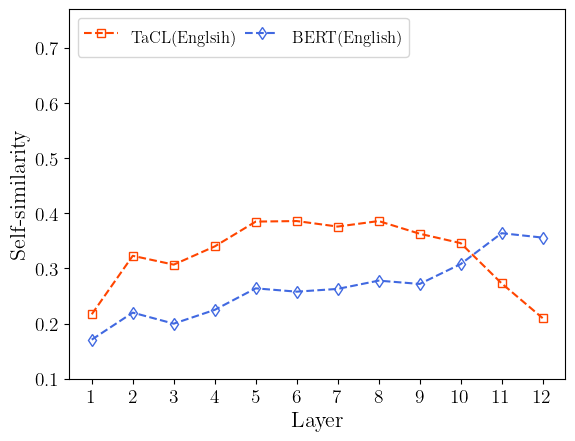

<Figure size 640x480 with 0 Axes>

In [19]:
generategraphs()

Line graph is generated to show layer wise self-similarity

##Correaltion Matrix of Tokens in a Sentence is generated.

In [ ]:
#function computes the correlation matrix of the hidden states
def compute_correlation_matrix(model, tokenizer, text):
    # Adds special tokens to the input text and tokenize it
    text = '[CLS] ' + text.strip('\n') + ' [SEP]'
    token_list = tokenizer.tokenize(text)

    # Convert tokens to input ids and get the input sequence length
    input_ids = torch.LongTensor(tokenizer.convert_tokens_to_ids(token_list)).view(1,-1)
    _, seq_len = input_ids.size()

    # Pass the input ids through the model to get the hidden states
    hidden = model(input_ids).last_hidden_state

    # Normalize the hidden states along the last dimension
    norm_hidden = hidden / hidden.norm(dim=2, keepdim=True)

    # Compute the correlation matrix of the hidden states
    correlation_matrix = torch.matmul(norm_hidden, norm_hidden.transpose(1,2)).view(seq_len, seq_len)

    # Convert the correlation matrix tensor to a numpy array and return it, along with the token list
    return correlation_matrix.detach().numpy(), token_list


In [ ]:
# function generates correlation matrices and heatmaps for a given text using BERT and TaCL models.
def get_corr_matrix():
    # Load BERT
    model_name = 'bert-base-uncased'
    bert, bert_tokenizer = load_model_tokenizer(model_name)
    import matplotlib
    matplotlib.use('Agg')

    # Load TaCL
    model_name = 'cambridgeltl/tacl-bert-base-uncased'
    tacl, tacl_tokenizer = load_model_tokenizer(model_name)

    # Define the input text
    text = "Today's weather was pleasant, but Linda felt it was unpleasant."

    # Compute the correlation matrix for BERT
    bert_res, token_list = compute_correlation_matrix(bert, bert_tokenizer, text)

    # Clean up the token list for better visualization
    final_token_list=[]
    j=0
    r=0
    for i in token_list:
        if i.startswith("#")== True:
            i=i.replace("#","symbol ")
        final_token_list.append(i)
    print(final_token_list)

    # Create a dataframe to store the correlation matrix and visualize it as a heatmap for BERT
    df = pd.DataFrame(bert_res, 
                      index=final_token_list,
                      columns=final_token_list)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(df, cmap="Oranges",ax=ax)
    plt.savefig('bert_heatmap.png', format='png', dpi=500)
    plt.show()

    # Compute the correlation matrix for TaCL
    tacl_res, token_list = compute_correlation_matrix(tacl, tacl_tokenizer, text)

    # Create a dataframe to store the correlation matrix and visualize it as a heatmap for TaCL
    df = pd.DataFrame(tacl_res, 
                      index=final_token_list,
                      columns=final_token_list)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(df, cmap="Oranges",ax=ax)
    plt.savefig('tacl_heatmap.png', format='png', dpi=500)
    plt.show()


In [ ]:
get_corr_matrix()

Two heat maps are generated "tacl_heatmap.png","bert_heatmap.png" for token self-similarity.